In [47]:
import pandas as pd
import numpy as np
from sklearn.naive_bayes import BernoulliNB, GaussianNB
from sklearn.metrics import roc_auc_score, confusion_matrix
from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
import seaborn as sns
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'retina' # для более четкой отрисовки графиков

In [13]:
ds = pd.read_excel('fire_dataset.xlsx', index_col=0)
ds = ds.drop(['lon', 'lat', 'Dist_str', 'Dist_railw', 'Dist_car'], axis=1) # удалим признаки описывающие только термоточку
print('Размер датасета: {}'.format(ds.shape))

Размер датасета: (8166, 16)


In [14]:
ds.head()

,area,T,Po,P,Pa,U,DD,Ff,N,WW,Cl,Nh,H,Cm,VV,Td
2017-09-24 10:00:00,0,9.4,761.9,774.8,0.1,71,"Ветер, дующий с востока",2,100%.,NaN,"Слоисто-кучевые, образовавшиеся не из кучевых.",50%.,600-1000,"Высококучевые просвечивающие, расположенные на...",10.0,4.3
2017-09-24 13:00:00,0,11.7,762.4,775.2,0.5,56,"Ветер, дующий с северо-северо-востока",3,70 – 80%.,NaN,"Слоисто-кучевые, образовавшиеся не из кучевых.",70 – 80%.,600-1000,"Высококучевых, высокослоистых или слоисто-дожд...",10.0,3.1
2017-09-24 16:00:00,0,11.6,762.7,775.6,0.3,53,"Ветер, дующий с северо-востока",2,70 – 80%.,NaN,"Слоисто-кучевые, образовавшиеся не из кучевых.",70 – 80%.,600-1000,"Высококучевых, высокослоистых или слоисто-дожд...",10.0,2.3
2017-09-24 19:00:00,0,7.7,763.3,776.4,0.6,64,"Ветер, дующий с северо-востока",2,70 – 80%.,NaN,"Кучево-дождевые лысые с кучевыми, слоисто-куче...",70 – 80%.,600-1000,"Высококучевых, высокослоистых или слоисто-дожд...",10.0,1.2
2017-09-24 22:00:00,0,6.1,763.6,773.7,0.3,77,"Ветер, дующий с севера",1,Облаков нет.,NaN,"Кучево-дождевые лысые с кучевыми, слоисто-куче...",70 – 80%.,600-1000,"Высококучевых, высокослоистых или слоисто-дожд...",10.0,2.3


In [15]:
ds = ds.rename(columns={'area':'target'}) # переименую целевую переменную

In [19]:
# создадим временные фичи
ds['month'] = ds.index.month
ds['day'] = ds.index.day
ds['weekday'] = ds.index.day_of_week

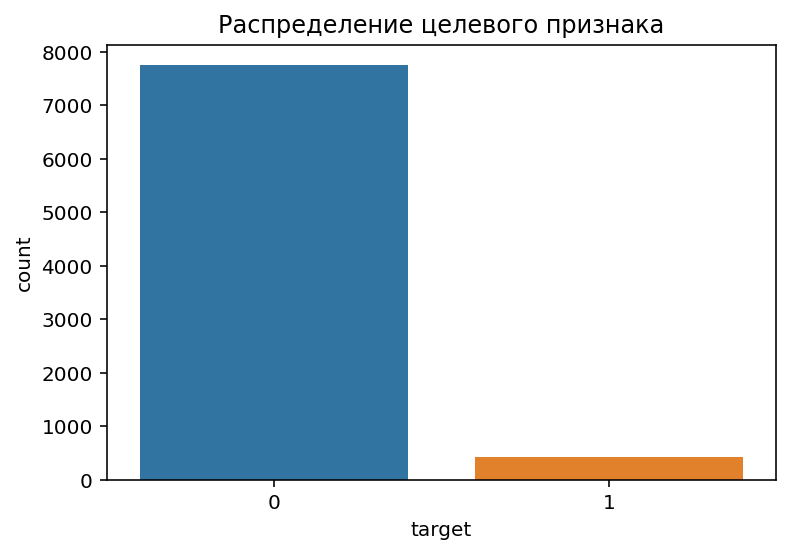

In [5]:
sns.countplot(x=ds['target']).set_title('Распределение целевого признака');

In [20]:
num_cols = ds.drop(['target'], axis=1).select_dtypes(exclude='O').columns # числовые признаки
cat_cols = ds.select_dtypes(include='O').columns # категориальнве признаки

In [21]:
ds.isna().sum() # кол-во пропушенных элементов

target        0
T             0
Po            0
P             0
Pa            0
U             0
DD            0
Ff            0
N             0
WW         5831
Cl            0
Nh            0
H             0
Cm            0
VV            0
Td            0
month         0
day           0
weekday       0
dtype: int64

In [22]:
ds.drop(['WW'], axis=1, inplace=True) # нет больше половины данных --> удалим признак

In [23]:
ds = pd.get_dummies(ds) # преобразуем категориальные признаки

In [24]:
x_train, x_test, y_train, y_test = train_test_split(ds.drop(['target'], axis=1), 
                                                    ds['target'],
                                                    test_size=0.3
                                                   ) # разделим на тренировочную и тестовую выборки

In [25]:
transformer = PowerTransformer(standardize=True)
x_train[num_cols] = transformer.fit_transform(x_train[num_cols]) # нормализуем и стандартизуем числовые переменные
x_test[num_cols] = transformer.transform(x_test[num_cols]) # нормализуем и стандартизуем числовые переменные

In [52]:
x_train.head()

,T,Po,P,Pa,U,Ff,VV,Td,month,day,...,H_300-600,H_600-1000,Cm_Высококучевые башенкообразные или хлопьевидные.,"Cm_Высококучевые просвечивающие, полосами, либо один или несколько слоев высококучевых просвечивающих, распространяющихся по небу; эти высококучевые в целом уплотняются.","Cm_Высококучевые просвечивающие, расположенные на одном уровне.","Cm_Высококучевые, образовавшиеся из кучевых (или кучево-дождевых).","Cm_Высококучевые, просвечивающие или плотные в двух или более слоях или высококучевые плотные в одном слое, не распространяющиеся но небу, либо высококучевые с высокослоистыми или слоисто-дождевыми.","Cm_Высококучевых, высокослоистых или слоисто-дождевых облаков нет.",Cm_Высокослоистые непросвечивающие или слоисто-дождевые.,Cm_Высокослоистые просвечивающие.
2018-07-16 13:00:00,2.023764,-0.915016,-1.035821,-0.605945,-1.422497,0.168999,0.239080,1.848390,0.175782,0.135259,...,0,1,0,0,0,0,0,1,0,0
2017-11-11 01:00:00,-0.553119,0.999258,1.014024,-0.008413,0.930613,0.168999,0.239080,-0.323805,1.183476,-0.415163,...,0,1,0,0,1,0,0,0,0,0
2018-03-22 13:00:00,-0.628887,-1.970548,-1.891325,0.392219,0.692286,0.168999,-2.219592,-0.482943,-0.994862,0.737597,...,0,1,0,0,1,0,0,0,0,0
2020-03-14 16:00:00,-0.267090,-1.268883,-1.223242,-1.299306,1.430141,-0.853567,-2.219592,0.140696,-0.994862,-0.078471,...,1,0,0,0,0,0,0,0,1,0
2020-05-15 04:00:00,0.028195,-0.255048,-0.236763,-0.506600,0.633914,-2.114314,0.239080,0.318940,-0.381193,0.029347,...,0,0,0,0,0,0,0,1,0,0


In [34]:
def get_cross_val_score(x, y, model, cv):
    """Функция для оценки модели на кросс-валидации"""
    cv_score = cross_val_score(model, x, y, scoring='roc_auc', cv=cv, n_jobs=-1) # прогоняем модель на кросс-валидации
    print(model.__class__.__name__)
    print('ROC-AUC на кросс-валидации: %.3f+-%.3f'% (np.mean(cv_score), np.std(cv_score)))

In [36]:
skf = StratifiedKFold(n_splits=7) # схема для кросс-валидации

for model in [
    BernoulliNB(),
    GaussianNB(),
]:
    get_cross_val_score(x_train, y_train, model, skf) # получим результаты на кросс-валидации
    

BernoulliNB
Точность модели на кросс-валидации: 0.775+-0.040
GaussianNB
Точность модели на кросс-валидации: 0.582+-0.015


In [39]:
model = BernoulliNB()
params = {'alpha': (0.1, 1, 2), 'binarize': (0, 0.1, 0.1)} # параметры для подбора
model_grid = GridSearchCV(model, param_grid=params, scoring='roc_auc', n_jobs=-1, cv=skf)
model_grid.fit(x_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=7, random_state=None, shuffle=False),
             estimator=BernoulliNB(), n_jobs=-1,
             param_grid={'alpha': (0.1, 1, 2), 'binarize': (0, 0.1, 0.1)},
             scoring='roc_auc')

In [44]:
print('Лучшая модель на кросс-валидации с параметрами {} и ROC_AUC = {}'.format(model_grid.best_params_, 
                                                                        np.round(model_grid.best_score_,4)))

best_model = model_grid.best_estimator_

Лучшая модель на кросс-валидации с параметрами {'alpha': 0.1, 'binarize': 0.1} и ROC_AUC = 0.7821


In [45]:
best_model.fit(x_train, y_train)
print('ROC-AUC на тестовой выборке: %.3f' % roc_auc_score(y_test, best_model.predict(x_test)))

ROC-AUC на тестовой выборке: 0.659


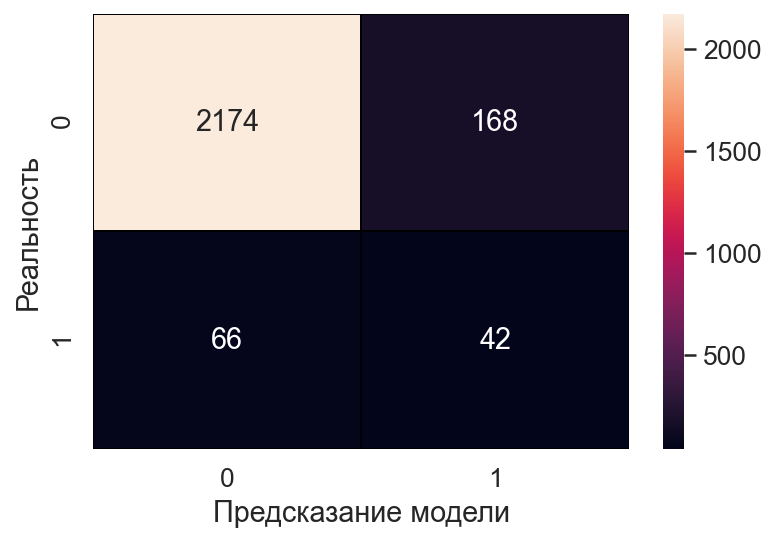

In [55]:
sns.set(font_scale=1.2)
sns.heatmap(confusion_matrix(y_test, best_model.predict(x_test)), 
            annot=True, 
            fmt = '.0f',
            linewidths=0.1,
            linecolor='black'
           )
plt.xlabel('Предсказание модели')
plt.ylabel('Реальность');